# Actor Effects

Objectively, it is hard to measure how good an actor is and their contribution to a movie's rating. One possible measure is the average rating of all their works - but if the actor only has one work under their belt, for example, then the average value will also perfectly predict the movie's rating. Think of a fixed effects model, but with only one time period.

Douban has a feature where users can add themselves as a fan of their favourite actors. The number of fans an actor has is displayed on the actor's page, and we can use this number as a proxy for the actor's popularity.

The problem arises when actors collaborate on a movie. One actor's fans will likely be a subset of another actor's. How then can we assess the collective contribution of the actors to the movie's success? Without access to the granular data of each individual fan, which would be far too cumbersome to scrape, we cannot compute the total set of fans of the actors in the movie.

There are two approaches. The first is to sum the total number of fans of the actors. This will tend to overstate the number of fans. The second is to take the maximum of the number of fans of the actors. Since actor's fanbases will not be perfect subsets, this will tend to understate the number of fans.

This notebook explores these two approaches, and the resulting measure we will call "actor effects". Similarly if a movie has multiple directors or writers, they will be called director effects etc.

In [1]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
converters={"director":literal_eval, "author":literal_eval, "actor":literal_eval, "genre":literal_eval}
movies = pd.read_csv("./data/movies_df.csv", index_col=0, converters=converters)
movies = movies[movies.year >= 2010]
movies = movies[movies.language.str.contains("汉语普通话", na=True)]
movies.head()

,id,name,year,url,image,director,author,actor,datePublished,genre,language,duration,description,ratingCount,bestRating,worstRating,ratingValue
0,10344754,毒战 毒戰,2012,/subject/10344754/,https://img9.doubanio.com/view/photo/s_ratio_p...,"[{'@type': 'Person', 'url': '/celebrity/116018...","[{'@type': 'Person', 'url': '/celebrity/101784...","[{'@type': 'Person', 'url': '/celebrity/105358...",2012-11-15,"[剧情, 动作, 犯罪]",汉语普通话 / 粤语,PT1H48M,刚刚结束一次危险任务的津海市缉毒大队队长张雷（孙红雷 饰），在医院意外见到因车祸入院治疗的香...,210072,10,2,7.5
1,10355621,粉红女郎之爱人快跑,2013,/subject/10355621/,https://img2.doubanio.com/view/photo/s_ratio_p...,"[{'@type': 'Person', 'url': '/celebrity/131860...","[{'@type': 'Person', 'url': '/celebrity/131860...","[{'@type': 'Person', 'url': '/celebrity/131445...",2013-08-23,"[喜剧, 爱情]",汉语普通话,PT1H41M,为了泡到一个男朋友，结婚狂（阿雅 饰）碰见魔术师高明（锦荣 饰）后，便告诉对方自己怀了他的孩...,1826,10,2,3.2
2,10355633,绝命藏宝图,2012,/subject/10355633/,https://img2.doubanio.com/view/photo/s_ratio_p...,"[{'@type': 'Person', 'url': '/celebrity/127456...","[{'@type': 'Person', 'url': '/celebrity/127456...","[{'@type': 'Person', 'url': '/celebrity/127456...",NaN,"[动作, 悬疑]",汉语普通话,PT1H31M,一对不食人间烟火的青年男女——彭少文和程雪珂狼狈地逃到余姚县城门口，他们身后有一群凶神恶煞的...,78,10,2,3.2
4,10430281,七个隆咚锵咚锵,2012,/subject/10430281/,https://img9.doubanio.com/view/photo/s_ratio_p...,"[{'@type': 'Person', 'url': '/celebrity/131737...","[{'@type': 'Person', 'url': '/celebrity/131737...","[{'@type': 'Person', 'url': '/celebrity/131737...",2012-01-25,"[喜剧, 爱情]",汉语普通话,PT1H39M,韩峰（韩兆 饰）在一天之内丢掉了工作和恋人，一无所有的他陷入了人生的低谷之中。然而，韩峰的运...,506,10,2,4.9
5,10437802,武当少年 武當少年,2010,/subject/10437802/,https://img9.doubanio.com/view/photo/s_ratio_p...,"[{'@type': 'Person', 'url': '/celebrity/132082...","[{'@type': 'Person', 'url': '/celebrity/132082...","[{'@type': 'Person', 'url': '/celebrity/131732...",NaN,"[剧情, 儿童]",汉语普通话,PT1H30M,主人公翔翔原本是一个天真浪漫，活泼好动的孩子，在一次观看武当武校在台湾的表演后，萌生了赴武当...,68,10,2,6.1


In [3]:
len(movies)

2996

In [4]:
celebs = pd.read_csv("./data/celebs_df.csv", index_col=0)

In [5]:
# who has the most fans?
celebs.sort_values("fans").tail()

,id,name,fans,性别,星座,出生日期,出生地,职业,更多外文名,更多中文名,家庭成员,imdb编号,生卒日期,去世日期
6040,1340022,易烊千玺 Jackson Yee,112902,NaN,射手座,2000年11月28日,"中国,湖南,怀化",演员 / 配音 / 音乐,Yi Yangqianxi / Jackson Yi / Jackson Yee,NaN,爸爸 妈妈 弟弟,NaN,NaN,NaN
797,1054444,昆汀·塔伦蒂诺 Quentin Tarantino,119245,男,白羊座,1963年03月27日,"美国,田纳西州,诺克斯维尔",演员 / 编剧 / 制片人 / 导演 / 配音,Quentin Jerome Tarantino (本名) / QT (昵称),昆汀塔伦天奴 / 昆汀塔伦提诺,Daniella Pick(妻),NaN,NaN,NaN
594,1041029,莱昂纳多·迪卡普里奥 Leonardo DiCaprio,136304,男,天蝎座,1974年11月11日,"美国,加利福尼亚,洛杉矶",演员 / 制片人 / 配音 / 编剧,Leonardo Wilhelm DiCaprio (本名) / Lenny D (昵称) ...,李奥纳多·迪卡普里奥 / 里安纳度·迪卡比奥 / 小李(昵称) / 小李子(昵称),Gisele Bündchen(前女友) / Bar Refaeli(前女友) / Erin...,NaN,NaN,NaN
7669,1354130,王一博 Yibo Wang,145570,男,狮子座,1997年08月05日,"中国,河南,洛阳",演员 / 配音,王一博,白牡丹 / 小王子,ss,NaN,NaN,NaN
8362,1360615,肖战 Zhan Xiao,294605,男,天秤座,1991年10月05日,"中国,重庆",演员,Sean Xiao,NaN,爸爸 / 妈妈 / 坚果（猫）,NaN,NaN,NaN


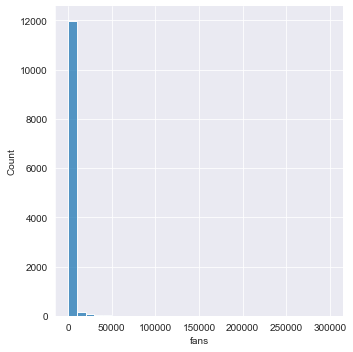

In [21]:
# the vast majority of celebs have fewer than 10 thousand followers.
sns.displot(celebs, x="fans", binwidth=10000)

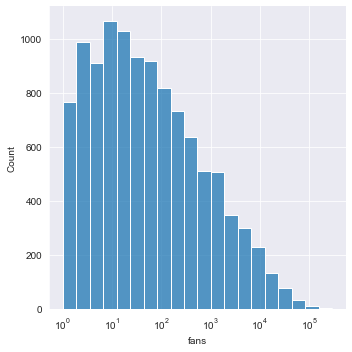

In [25]:
# a log scale makes it more even. Note log 0 is neg infinity so we filter out those with 0 fans
sns.displot(celebs[celebs.fans > 0], x="fans", bins=20, log_scale=True)

In [5]:
def get_max_effects(col: pd.Series) -> []:
    effects = []
    for movie in col:
        max_fans: int = 0
        for actor in movie:
            i = int(actor["url"].split("/")[2])
            try:
                fans = int(celebs[celebs.id == i].iloc[0].fans)
                if fans > max_fans:
                    max_fans = fans
            except IndexError:
                # remember that we only scraped details of lead actors, so some actors won't be found
                pass
        effects.append(max_fans)
    return effects

def get_sum_effects(col: pd.Series) -> []:
    effects = []
    for movie in col:
        fans = 0
        for actor in movie:
            i = int(actor["url"].split("/")[2])
            try:
                fans += int(celebs[celebs.id == i].iloc[0].fans)
            except IndexError:
                # remember that we only scraped details of lead actors, so some actors won't be found
                pass
        effects.append(fans)
    return effects

## Exploring Max Effects

In [6]:
movies.insert(len(movies.columns), "directorMaxEffect", get_max_effects(movies.director))
movies.insert(len(movies.columns), "actorMaxEffect", get_max_effects(movies.actor))
movies.insert(len(movies.columns), "writerMaxEffect", get_max_effects(movies.author))

<AxesSubplot:xlabel='directorMaxEffect', ylabel='ratingValue'>

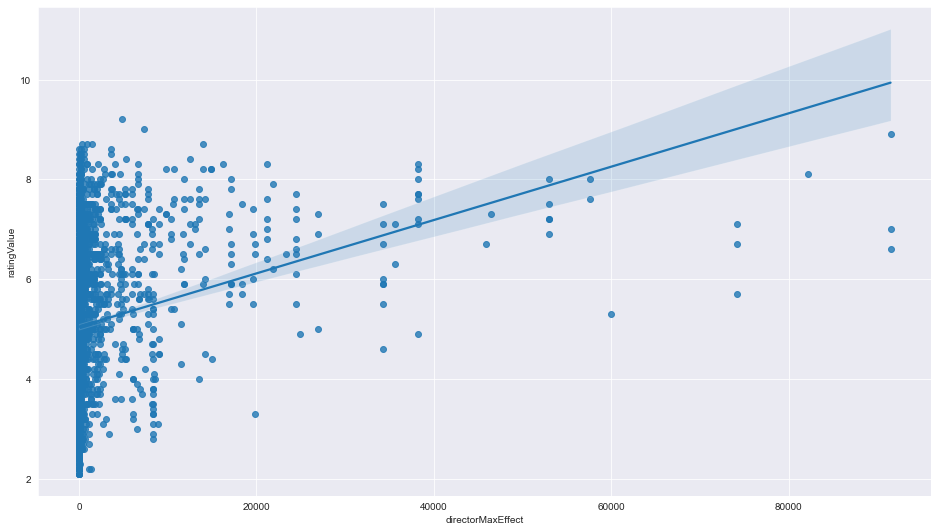

In [11]:
sns.regplot(x=movies.directorMaxEffect, y=movies.ratingValue)

<AxesSubplot:xlabel='actorMaxEffect', ylabel='ratingValue'>

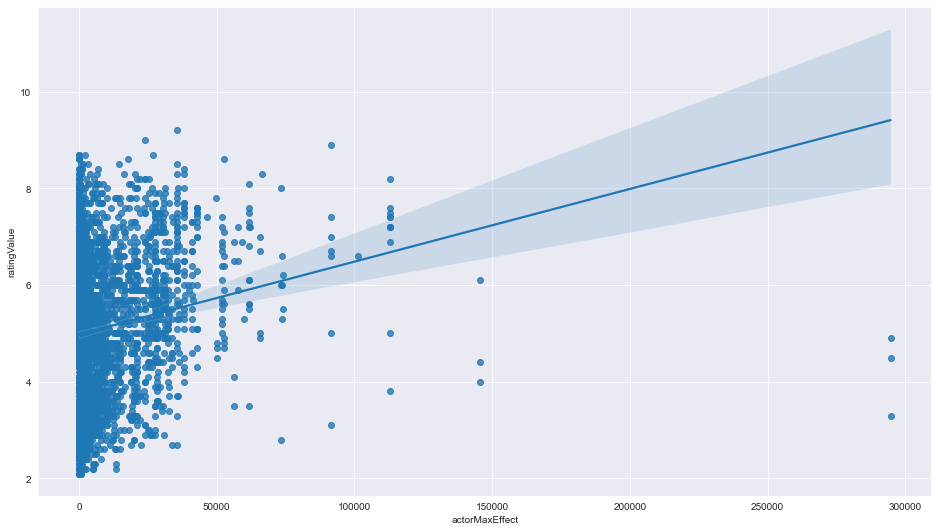

In [12]:
sns.regplot(x=movies.actorMaxEffect, y=movies.ratingValue)

<AxesSubplot:xlabel='writerMaxEffect', ylabel='ratingValue'>

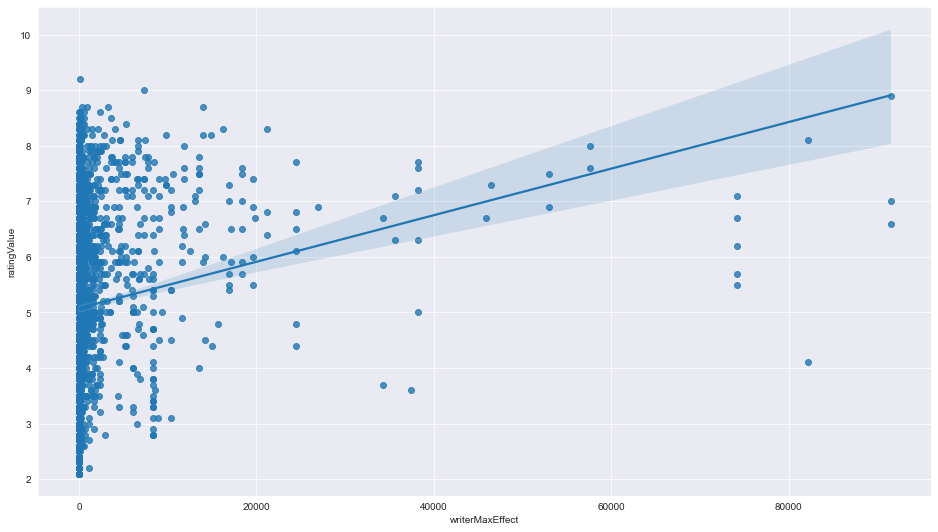

In [18]:
sns.regplot(x=movies.writerMaxEffect, y=movies.ratingValue)

## Exploring Sum Effects

In [7]:
movies.insert(len(movies.columns), "directorSumEffect", get_sum_effects(movies.director))
movies.insert(len(movies.columns), "actorSumEffect", get_sum_effects(movies.actor))
movies.insert(len(movies.columns), "writerSumEffect", get_sum_effects(movies.author))

<AxesSubplot:xlabel='directorSumEffect', ylabel='ratingValue'>

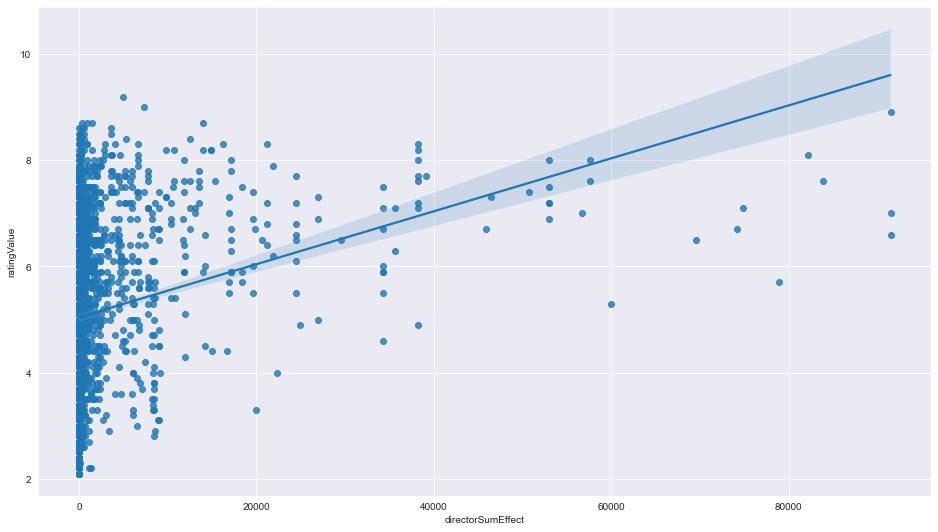

In [14]:
sns.regplot(x=movies.directorSumEffect, y=movies.ratingValue)

<AxesSubplot:xlabel='actorSumEffect', ylabel='ratingValue'>

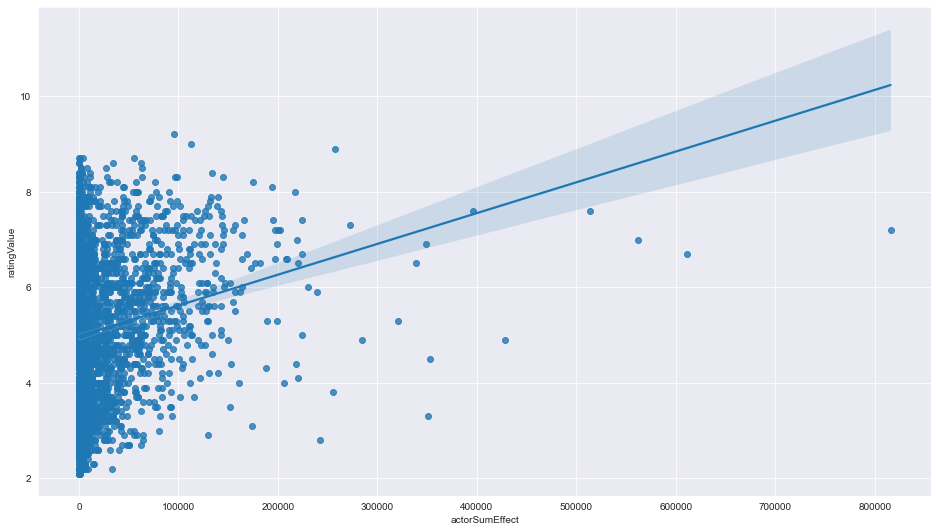

In [15]:
sns.regplot(x=movies.actorSumEffect, y=movies.ratingValue)

<AxesSubplot:xlabel='writerSumEffect', ylabel='ratingValue'>

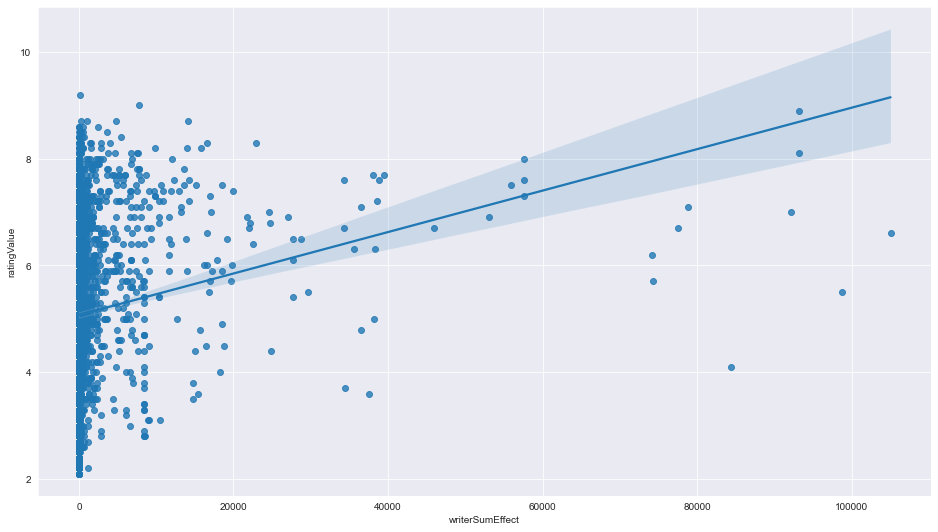

In [16]:
sns.regplot(x=movies.writerSumEffect, y=movies.ratingValue)

Well they're all positively correlated, which is definitely a good thing!

As for whether the max or sum effect provides a better fit, well that's hard to tell by eye.

What is the effect on rating count?

<AxesSubplot:xlabel='writerMaxEffect', ylabel='ratingCount'>

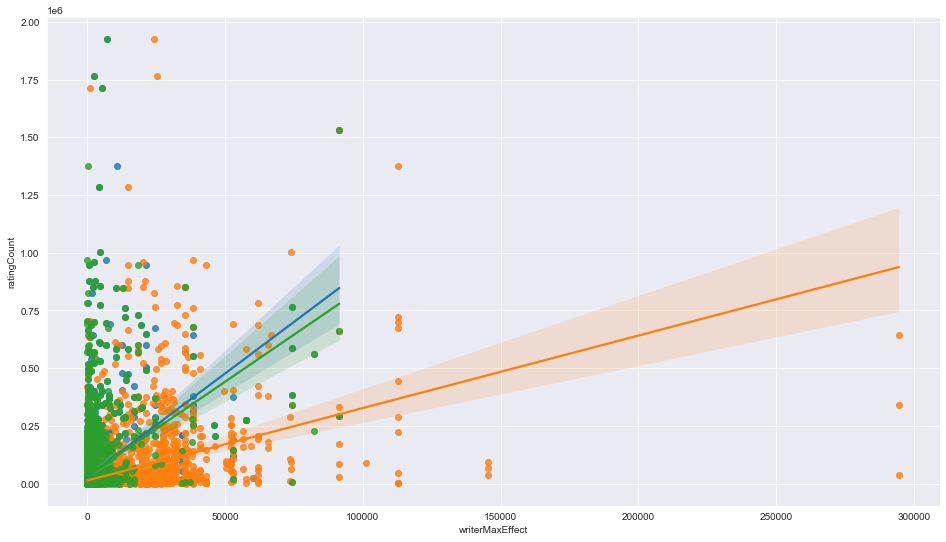

In [24]:
sns.regplot(x=movies.directorMaxEffect, y=movies.ratingCount)
sns.regplot(x=movies.actorMaxEffect, y=movies.ratingCount)
sns.regplot(x=movies.writerMaxEffect, y=movies.ratingCount)

<AxesSubplot:xlabel='writerSumEffect', ylabel='ratingCount'>

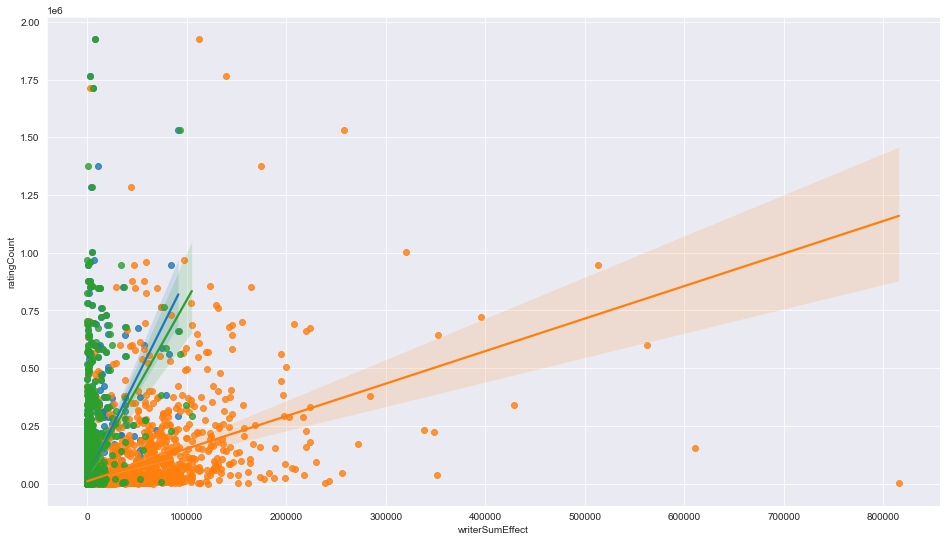

In [25]:
sns.regplot(x=movies.directorSumEffect, y=movies.ratingCount)
sns.regplot(x=movies.actorSumEffect, y=movies.ratingCount)
sns.regplot(x=movies.writerSumEffect, y=movies.ratingCount)

Summing the actor fans clearly exaggerates the effect on rating count, as seen by the shallow gradient of the orange line.

Another thing is that there are many outliers, with most movies having less than 1e6 number of ratings. Would it help if we logged the `ratingCount`?

In [10]:
import numpy as np

<AxesSubplot:xlabel='directorSumEffect', ylabel='ratingCount'>

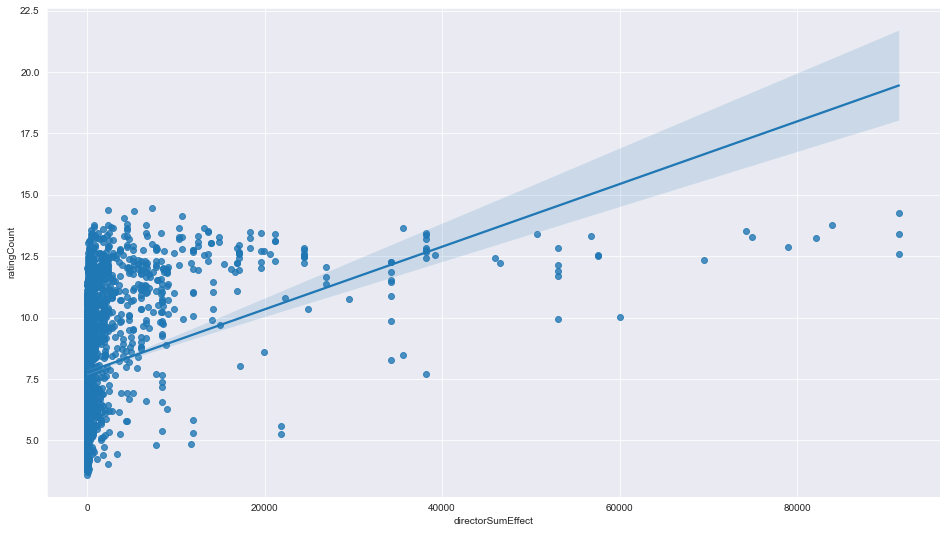

In [12]:
sns.regplot(x=movies.directorSumEffect, y=np.log(movies.ratingCount))

## Comparing max and sum effects

<AxesSubplot:xlabel='directorSumEffect', ylabel='directorMaxEffect'>

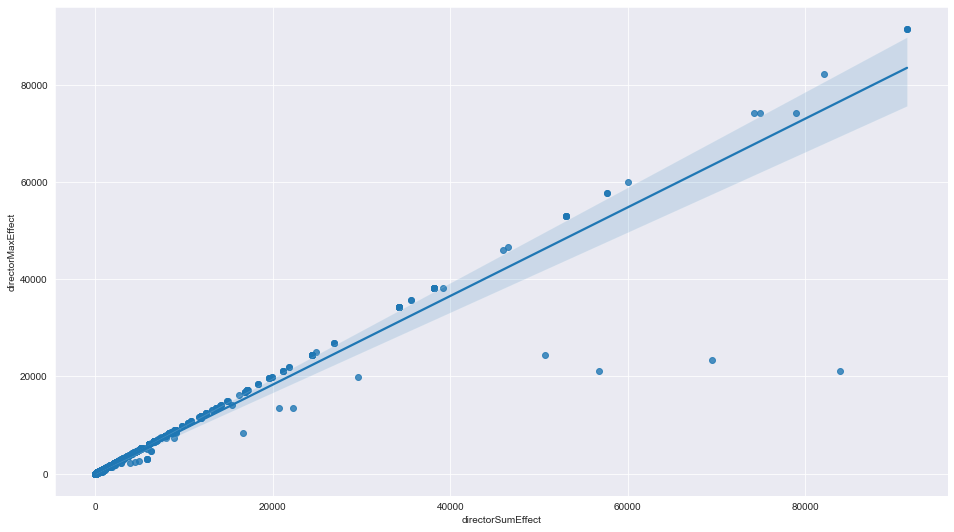

In [11]:
sns.regplot(x=movies.directorSumEffect, y=movies.directorMaxEffect)

<AxesSubplot:xlabel='actorSumEffect', ylabel='actorMaxEffect'>

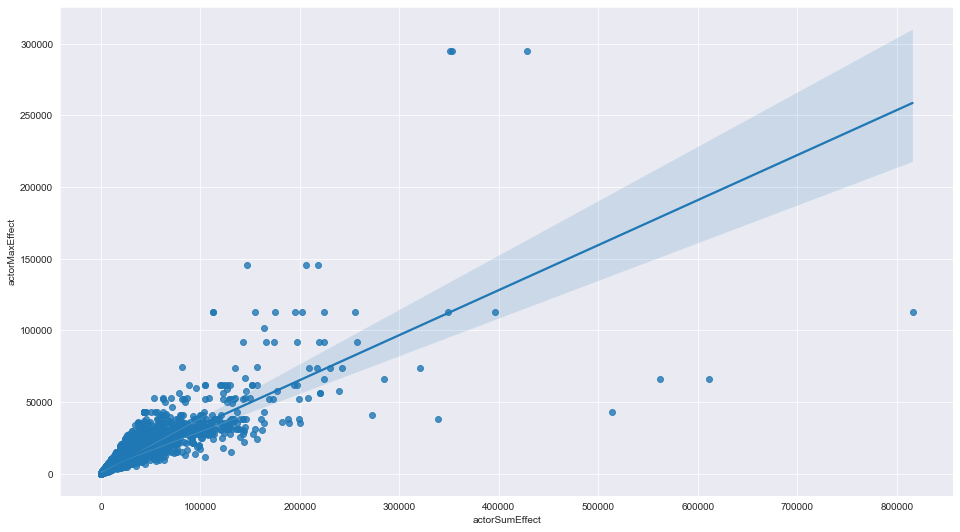

In [12]:
sns.regplot(x=movies.actorSumEffect, y=movies.actorMaxEffect)

<AxesSubplot:xlabel='writerSumEffect', ylabel='writerMaxEffect'>

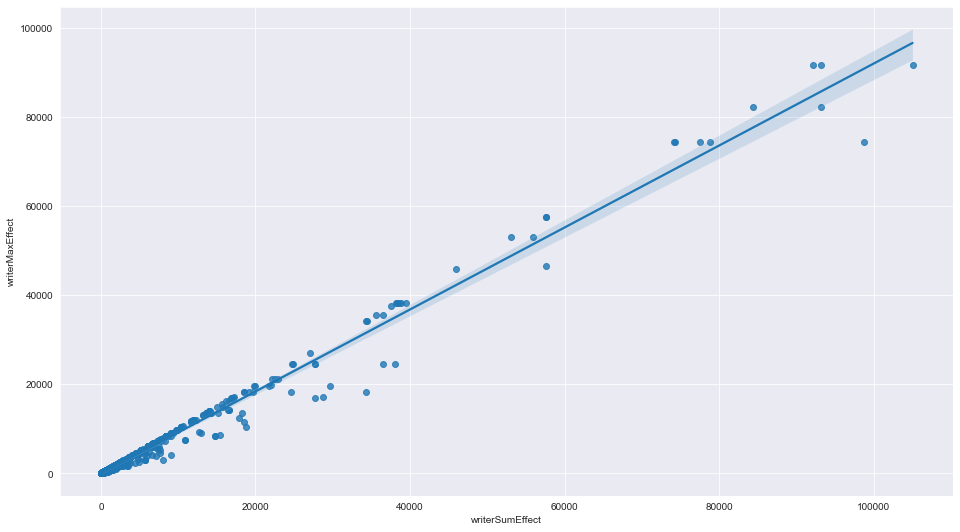

In [13]:
sns.regplot(x=movies.writerSumEffect, y=movies.writerMaxEffect)

Because movies usually have one director or writer, the correlation between the max and sum effects is quite high.

However for actor effects this is not the case. Movies to the bottom right signify many actors, each with few followers, making up an ensemble cast. Movies to the top left are where a single superstar with many followers dominates an entire cast.

In [8]:
# write actor effects to file
movies.head()

,id,name,year,url,image,director,author,actor,datePublished,genre,...,ratingCount,bestRating,worstRating,ratingValue,directorMaxEffect,actorMaxEffect,writerMaxEffect,directorSumEffect,actorSumEffect,writerSumEffect
0,10344754,毒战 毒戰,2012,/subject/10344754/,https://img9.doubanio.com/view/photo/s_ratio_p...,"[{'@type': 'Person', 'url': '/celebrity/116018...","[{'@type': 'Person', 'url': '/celebrity/101784...","[{'@type': 'Person', 'url': '/celebrity/105358...",2012-11-15,"[剧情, 动作, 犯罪]",...,210072,10,2,7.5,34235,27592,5441,34235,107664,7410
1,10355621,粉红女郎之爱人快跑,2013,/subject/10355621/,https://img2.doubanio.com/view/photo/s_ratio_p...,"[{'@type': 'Person', 'url': '/celebrity/131860...","[{'@type': 'Person', 'url': '/celebrity/131860...","[{'@type': 'Person', 'url': '/celebrity/131445...",2013-08-23,"[喜剧, 爱情]",...,1826,10,2,3.2,65,3861,65,65,13658,65
2,10355633,绝命藏宝图,2012,/subject/10355633/,https://img2.doubanio.com/view/photo/s_ratio_p...,"[{'@type': 'Person', 'url': '/celebrity/127456...","[{'@type': 'Person', 'url': '/celebrity/127456...","[{'@type': 'Person', 'url': '/celebrity/127456...",NaN,"[动作, 悬疑]",...,78,10,2,3.2,43,43,43,43,69,43
4,10430281,七个隆咚锵咚锵,2012,/subject/10430281/,https://img9.doubanio.com/view/photo/s_ratio_p...,"[{'@type': 'Person', 'url': '/celebrity/131737...","[{'@type': 'Person', 'url': '/celebrity/131737...","[{'@type': 'Person', 'url': '/celebrity/131737...",2012-01-25,"[喜剧, 爱情]",...,506,10,2,4.9,115,161,115,115,340,115
5,10437802,武当少年 武當少年,2010,/subject/10437802/,https://img9.doubanio.com/view/photo/s_ratio_p...,"[{'@type': 'Person', 'url': '/celebrity/132082...","[{'@type': 'Person', 'url': '/celebrity/132082...","[{'@type': 'Person', 'url': '/celebrity/131732...",NaN,"[剧情, 儿童]",...,68,10,2,6.1,2,192,2,2,233,2


In [9]:
movies.to_csv("./data/movies_actors_df.csv")